## Intro
In general I did the analysis for 4 categories:
- Magic (= magic + follow up of magic event)
- Low magic
- All magic (= magic + follow up + low magic)
- Others (=rest of the book)

In [12]:
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import scipy
import epub
import nltk
import pandas as pd
import seaborn as sns; sns.set()
import numpy as np
from bs4 import BeautifulSoup
from collections import Counter, OrderedDict
from string import punctuation
from itertools import combinations
from helper import *
import re


from scipy.stats import ks_2samp

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Text preparation and magical passages

Loading the text from the file

In [13]:
book = epub.open_epub('GabrielGarciaMarquez-CienAnosDeSoledad.EPUB')
cienanos = []
for item in list(book.opf.manifest.values())[4:24]: 
    # read the content 
    data = book.read_item( item )
    if 'html' in item.href and 'chap' in item.href:
        print(item.href)
    #print data
    soup = BeautifulSoup(data, 'html.parser')
    raw = soup.prettify()
    chapter_num = soup.h1.text.strip()
    paragraphs = [par.get_text() for par in soup.find_all('div', class_='paragraph5')]
    cienanos.append((chapter_num, paragraphs))

In [14]:
paragraphs = []
for chapter in cienanos:
    for paragraph in chapter[1]:
        paragraphs.append(paragraph)
paragraphs = np.array(paragraphs)
print("There is %d paragraph of average length %.3f words"%(len(paragraphs), sum(len(s.split()) for s in paragraphs)/len(paragraphs)))

There is 840 paragraph of average length 164.005 words


In [ ]:
from nltk.parse.corenlp import *
parser = CoreNLPParser(url='http://127.0.0.1:9000')

paragraphs_tokenized = []
for paragraph in paragraphs:
    paragraphs_tokenized.append([])
    for sentence in nltk.sent_tokenize(paragraph, language='spanish'):
        paragraphs_tokenized[-1].append(list(parser.tokenize(sentence)))

In [15]:
import json
with open('paragraphs_tokenized.json', 'r', encoding='utf-8') as infile:
    paragraphs_tokenized = json.load(infile)
    paragraphs_tokenized = np.array([np.array([np.array(sentence) for sentence in paragraph]) for paragraph in paragraphs_tokenized])


Several passages we selected contained two different paragraphs, I chose to put them as two separate paragraphs

In [16]:
follow_up_passages = []
follow_up_passages.append("Aturdido por la noticia, José Arcadio Buendía permaneció inmóvil, tratando de sobreponerse a la aflicción, hasta que el grupo se dispersó reclamado por otros artificios y el charco del armenio taciturno se evaporó por completo.")
# follow_up_passages.append("La embriaguez del poder empezó a descomponerse en ráfagas de desazón. Buscando un remedio contra el frío, hizo fusilar al joven oficial que propuso el asesinato del general Teófilo Vargas.")
# follow_up_passages.append("Solo, abandonado por los presagios, huyendo del frío que había de acompañarlo hasta la muerte, buscó un último refugio en Macondo, al calor de sus recuerdos más antiguos.")
follow_up_passages.append("Aunque carecía de pastas y el título no aparecía por ninguna parte, el niño gozaba con la historia de una mujer que se sentaba a la mesa y sólo comía granos de arroz que prendía con alfileres, y con la historia del pescador que le pidió prestado a su vecino un plomo para su red y el pescado con que lo recompensó más tarde tenía un diamante en el estómago, y con la lámpara que satisfacía los deseos y las alfombras que volaban. Asombrado, le preguntó a Úrsula si todo aquello era verdad, y ella le contentó que sí, que muchos años antes los gitanos llevaban a Macondo las lámparas maravillosas y las esteras voladoras.")
#follow_up_passages.append("—Lo que pasa —suspiró— es que el mundo se va acabando poco a poco y ya no vienen esas cosas.")
follow_up_passages.append("Fue por eso que decidió apartarla del mundo, preservarla de toda tentación terrenal, sin saber que Remedios, la bella, ya desde el vientre de su madre, estaba a salvo de cualquier contagio.")
follow_up_passages.append("Siendo muy niña, una noche de luna, Fernanda vio una hermosa mujer vestida de blanco que atravesó el jardín hacia el oratorio. Lo que más le inquietó de aquella visión fugaz fue que la sintió exactamente igual a ella, como si se hubiera visto a sí misma con veinte años de anticipación. «Es tu bisabuela, la reina —le dijo su madre en las treguas de la tos—. Se murió de un mal aire que le dio al cortar una vara de nardos.» Muchos años después, cuando empezó a sentirse igual a su bisabuela, Fernanda puso en duda la visión de la infancia, pero la madre la reprochó su incredulidad.")
follow_up_passages.append("Fue en esa ocasión cuando construyeron una fortaleza de hormigón sobre la descolorida tumba de José Arcadio, para que el olor a pólvora del cadáver no contaminara las aguas.")
follow_up_passages.append("Los forasteros, por supuesto, pensaron que Remedios, la bella, había sucumbido por fin a su irrevocable destino de abeja reina, y que su familia trataba de salvar la honra con la patraña de la levitación. Fernanda, mordida por la envidia, terminó por aceptar el prodigio, y durante mucho tiempo siguió rogando a Dios que le devolviera las sábanas. La mayoría creyó en el milagro, y hasta se encendieron velas y se rezaron novenarios.")
follow_up_passages.append("Llegó hasta denunciar la complicidad del padre Antonio Isabel, por haber marcado a sus hijos con ceniza indeleble para que fueran identificados por sus enemigos.")
follow_up_passages.append("El decrépito sacerdote que ya no hilvanaba muy bien las ideas y empezaba a espantar a los feligreses con las disparatadas interpretaciones que intentaba en el púlpito, apareció una tarde en la casa con el tazón donde preparaba las cenizas del miércoles, y trató de ungir con ellas a toda la familia para demostrar que se quitaban con agua. Pero el espanto de la desgracia había calado tan hondo, que ni la misma Fernanda se prestó al experimento, y nunca más se vio un Buendía arrodillado en el comulgatorio el miércoles de ceniza.")
follow_up_passages.append("La noticia de que Amaranta Buendía zarpaba al crepúsculo llevando el correo de la muerte se divulgó en Macondo antes del mediodía, y a las tres de la tarde había en la sala un cajón lleno de cartas. Quienes no quisieron escribir le dieron a Amaranta recados verbales que ella anotó en una libreta con el nombre y la fecha de muerte del destinatario")
follow_up_passages.append("Sólo entonces descubrió que Amaranta Úrsula no era su hermana, sino su tía, y que Francis Drake había asaltado a Riohacha solamente para que ellos pudieran buscarse por los laberintos más intrincados de la sangre, hasta engendrar el animal mitológico que había de poner término a la estirpe.")
follow_up_passages.append("Cuando se volvió con la pistola montada, la muchacha había bajado la suya y no sabía qué hacer.")

In [17]:
low_magical_passages = []
low_magical_passages.append("Está comprobado que el demonio tiene propiedades sulfúricas, y esto no es más que un poco de solimán.")
low_magical_passages.append("A esa hora, en Macondo, Úrsula destapó la olla de la leche en el fogón, extrañada de que se demorara tanto para hervir, y la encontró llena de gusanos")
low_magical_passages.append("El día de Año Nuevo, enloquecido por los desaires de Remedios, la bella, el joven comandante de la guardia amaneció muerto de amor junto a su ventana.")
low_magical_passages.append("Siendo muy niña, una noche de luna, Fernanda vio una hermosa mujer vestida de blanco que atravesó el jardín hacia el oratorio. Lo que más le inquietó de aquella visión fugaz fue que la sintió exactamente igual a ella, como si se hubiera visto a sí misma con veinte años de anticipación. «Es tu bisabuela, la reina —le dijo su madre en las treguas de la tos—. Se murió de un mal aire que le dio al cortar una vara de nardos.» Muchos años después, cuando empezó a sentirse igual a su bisabuela, Fernanda puso en duda la visión de la infancia, pero la madre la reprochó su incredulidad.")
low_magical_passages.append("Lo que ningún miembro de la familia supo nunca, fue que los forasteros no tardaron en darse cuenta de que Remedios, la bella, soltaba un hálito de perturbación, una ráfaga de tormento, que seguía siendo perceptible varias horas después de que ella había pasado. Hombres expertos en trastornos de amor, probados en el mundo entero, afirmaban no haber padecido jamás una ansiedad semejante a la que producía el olor natural de Remedios, la bella.")
low_magical_passages.append("La noticia de que Amaranta Buendía zarpaba al crepúsculo llevando el correo de la muerte se divulgó en Macondo antes del mediodía, y a las tres de la tarde había en la sala un cajón lleno de cartas. Quienes no quisieron escribir le dieron a Amaranta recados verbales que ella anotó en una libreta con el nombre y la fecha de muerte del destinatario")
low_magical_passages.append("Fue entonces cuando cayó en la cuenta de las mariposas amarillas que precedían las apariciones de Mauricio Babilonia.")
low_magical_passages.append("Catarino, que no creía en artificios de fuerza, apostó doce pesos a que no movía el mostrador. José Arcadio lo arrancó de su sitio, lo levantó en vilo sobre la cabeza y lo puso en la calle. Se necesitaron once hombres para meterlo.")
low_magical_passages.append("Escapó a catorce atentados, a setenta y tres emboscadas y a un pelotón de fusilamiento. Sobrevivió a una carga de estricnina en el café que habría bastado para matar un caballo.")
low_magical_passages.append("Aunque peleó siempre al frente de sus hombres, la única herida que recibió se la produjo él mismo después de firmar la capitulación de Neerlandia que puso término a casi veinte años de guerras civiles.")
low_magical_passages.append("Una noche cantó. Macondo despertó en una especie de estupor, angelizado por una cítara que no merecía ser de este mundo y una voz como no podía concebirse que hubiera otra en la tierra con tanto amor.")
low_magical_passages.append("Después de tres días de llanto, una tarde en que batía un dulce de leche en la cocina, oyó claramente la voz de su hijo muy cerca del oído. «Era Aureliano —gritó, corriendo hacia el castaño para darle la noticia al esposo—. No sé cómo ha sido el milagro, pero está vivo y vamos a verlo muy pronto.» Lo dio por hecho.")
low_magical_passages.append("«Ya sabe usted que soy adivino —bromeó él.")
low_magical_passages.append("Desde el principio de la adolescencia, cuando empezó a ser consciente de sus presagios, pensó que la muerte había d‹anunciarse con una señal definida, inequívoca, irrevocable, pero le faltaban pocas horas para morir, y la señal no llegaba. En cierta ocasión una mujer muy bella entró a su campamento de Tucurinca y pidió a los centinelas que le permitieran verlo. La dejaron pasar, porque conocían el fanatismo de algunas madres que enviaban a sus hijas al dormitorio de los guerreros más notables, según ellas mismas decían, para mejorar la raza. El coronel Aureliano Buendía estaba aquella noche terminando e poema del hombre que se había extraviado en la lluvia, cuando la muchacha entró al cuarto. Él le dio la espalda para poner la hoja en la gaveta con llave donde guardaba sus versos. Y entonces lo sintió. Agarró la pistola en la gaveta sin volver la cara.")
low_magical_passages.append("—No dispare, por favor —dijo.")
low_magical_passages.append("Cuando se volvió con la pistola montada, la muchacha había bajado la suya y no sabía qué hacer.")
low_magical_passages.append("Eran inútiles sus esfuerzos por sistematizar los presagios. Se presentaban d pronto, en una ráfaga de lucidez sobrenatural, como una convicción absoluta y momentánea, pero inasible. En ocasione eran tan naturales, que no las identificaba como presagios sin cuando se cumplían. Otras veces eran terminantes y no se cumplían. Con frecuencia no eran más que golpes vulgares de superstición.")
low_magical_passages.append("El día en que Úrsula lo visitó en la cárcel, después de mucho pensar, llegó a la conclusión de que quizá la muerte no se anunciaría aquella vez, porque no dependía del azar sino de la voluntad de sus verdugos.")
low_magical_passages.append("Nadie sabe cómo será, pero todo el mundo anda diciendo que el oficial que fusile al coronel Aureliano Buendía, y todos los soldados del pelotón, uno por uno, serán asesinados sin remedio, tarde o temprano, así se escondan en el fin del mundo.»")
low_magical_passages.append("Después de limpiarle el estómago con vomitivos, lo envolvió en frazadas calientes y le dio claras de huevos durante dos días, hasta que el cuerpo estragado recobró la temperatura normal. Al cuarto día estaba fuera de peligro.")
low_magical_passages.append("Un emisario especial llevó a la casa un sobre lacrado, dentro del cual había un papel escrito con la caligrafía preciosista del coronel: Cuiden mucho a papá porque se va a morir.")
low_magical_passages.append("Visitación le preguntó por qué había vuelto, y él le contestó en su lengua solemne:")
low_magical_passages.append("—He venido al sepelio del rey.")
low_magical_passages.append("En cierta ocasión estuvo a menos de veinte kilómetros de Macondo, y fue obligado por las patrullas del gobierno a internarse en las montañas muy cerca de la región encantada donde su padre encontró muchos años antes el fósil de un galeón español.")
low_magical_passages.append("En cierto modo, Aureliano José file el hombre alto y moreno que durante medio siglo le anunció el rey de copas, y que como todos los enviados de las barajas llegó a su corazón cuando ya estaba marcado por el signo de la muerte. Ella lo vio en los naipes.")
low_magical_passages.append("Aureliano José estaba destinado a conocer con ella la felicidad que le negó Amaranta, a tener siete hijos y a morirse de viejo en sus brazos, pero la bala de fusil que le entró por la espalda y le despedazó el pecho, estaba dirigida por una mala interpretación de las barajas. El capitán Aquiles Ricardo, que era en realidad quien estaba destinado a morir esa noche, murió en efecto cuatro horas antes que Aureliano José.")
low_magical_passages.append("A las doce, cuando Aureliano José acabó de desangrarse y Carmelita Montiel encontró en blanco los naipes de su porvenir, más de cuatrocientos hombres habían desfilado frente al teatro y habían descargado sus revólveres contra el cadáver abandonado del capitán Aquiles Ricardo. Se necesitó una patrulla para poner en una carretilla el cuerpo apelmazado de plomo, que se desbarataba como un pan ensopado.")
low_magical_passages.append("Después de buscarla inútilmente en el sabor de la tierra, en las cartas perfumadas de Pietro Crespi, en la cama tempestuosa de su marido, había encontrado la paz en aquella casa donde los recuerdos se materializaron por la fuerza de la evocación implacable, y se paseaban como seres humanos por los cuartos clausurados.")
low_magical_passages.append("Un frío interior que le rayaba las huesos y lo mortificaba inclusive a pleno salle impidió dormir bien varias meses, hasta que se le convirtió en una costumbre. La embriaguez del poder empezó a descomponerse en ráfagas de desazón. Buscando un remedio contra el frío, hizo fusilar al joven oficial que propuso el asesinato del general Teófilo Vargas.")
low_magical_passages.append("Solo, abandonado por los presagios, huyendo del frío que había de acompañarlo hasta la muerte, buscó un último refugio en Macondo, al calor de sus recuerdos más antiguos.")
low_magical_passages.append("había tenido que violar todos sus pactos con la muerte y revolcarse como un cerdo en el muladar de la gloria, para descubrir con casi cuarenta años de retraso los privilegios de la simplicidad.")
low_magical_passages.append("Úrsula comprendió entonces que no lo tendría en la casa por mucho tiempo. «Si no es la guerra —pensó— sólo puede ser la muerte.» Fue una suposición tan nítida, tan convincente, que la identificó como un presagio.")
low_magical_passages.append("La comparó con el recuerdo más antiguo que tenía de ella, la tarde en que él tuvo el presagio de que una olla de caldo hirviendo iba a caerse de la mesa, y la encontró despedazada.")
low_magical_passages.append("«Cuídate la boca», le dijo ella, y él se preguntó si la otra vez que se lo dijo, en el apogeo de la gloria, no había sido una visión sorprendentemente anticipada de su destino.")
low_magical_passages.append("Estaba fuera de peligro. El proyectil siguió una trayectoria tan limpia que el médico le metió por el pecho y le sacó por la espalda un cordón empapado de yodo. «Esta es mi obra maestra —le dijo satisfecho—. Era el único punto por donde podía pasar una bala sin lastimar ningún centro vital.» El coronel Aureliano Buendía se vio rodeado de novicias misericordiosas que entonaban salmos desesperados por el eterno descanso de su alma, y entonces se arrepintió de no haberse dado el tiro en el paladar como lo tenía previsto, sólo por burlar el pronóstico de Pilar Ternera.")
low_magical_passages.append("Un mediodía ardiente, mientras escrutaba los manuscritos, sintió que no estaba solo en el cuarto. Contra la reverberación de la ventana, sentado con las manos en las rodillas, estaba Melquíades.")
low_magical_passages.append("Desde entonces, durante varios años, se vieron casi todas las tardes. Melquíades le hablaba del mundo, trataba de infundirle su vieja sabiduría, pero se negó a traducir los manuscritos. «Nadie debe conocer su sentido mientras no hayan cumplido cien años», explicó. Aureliano Segundo guardó para siempre el secreto de aquellas entrevistas.")
low_magical_passages.append("El relato, que a tanta gente durante tanto tiempo le pareció fantástico, fue una revelación para José Arcadio Segundo.")
low_magical_passages.append("Pasó mucho tiempo antes de que lo consiguieran, y más les hubiera valido que la ocasión no llegara nunca, porque la mayoría de ellos no pudo recuperar jamás la placidez del sueño. El hombre que lo hizo posible, un forastero, perdió para siempre la serenidad, se enredó en los tremedales de la abyección y la miseria, y años después fue despedazado por un tren nocturno cuando se quedó dormido sobre los rieles.")
low_magical_passages.append("Ella la recibió con un gesto natural, como si hubiera estado preparada para aquel homenaje, y entonces se descubrió el rostro por un instante y dio las gracias con una sonrisa. Fue todo cuanto hizo. Pero no sólo para el caballero, sino para todos los hombres que tuvieron el desdichado privilegio de vivirlo, aquel fue un instante eterno.")
low_magical_passages.append("Cuando el joven comandante de la guardia le declaró su amor, lo rechazó sencillamente porque la asombró frivolidad. «Fíjate qué simple es —le dijo a Amaranta—. Dice que se está muriendo por mi, como si yo fuera un cólico miserere.» Cuando en efecto lo encontraron muerto junto a su ventana, Remedios, la bella, confirmó su impresión inicial.")
low_magical_passages.append("Había nacido y crecido a mil kilómetros del mar, en una ciudad lúgubre por cuyas callejuelas de piedra traqueteaban todavía, en noches de espantos, las carrozas de los virreyes.")
low_magical_passages.append("Era un intrincado frangollo de verdades y espejismos, que convulsionó de impaciencia al espectro de José Arcadio Buendía bajo el castaño y lo obligó a caminar por toda la casa aun a pleno día.")
low_magical_passages.append("Los forasteros que oyeron el estropicio en el comedor, y se apresuraron a llevarse el cadáver, percibieron en su piel el sofocante olor de Remedios, la bella. Estaba tan compenetrado con El cuerpo, que las grietas del cráneo no manaban sangre sino un aceite ambarino impregnado de aquel perfume secreto, y entonces comprendieron que el olor de Remedios, la bella, seguía torturando a los hombres más allá de la muerte, hasta el polvo de sus huesos. Sin embargo, no relacionaron aquel accidente de horror con los otros dos hombres que habían muerto por Remedios, la bella. Faltaba todavía una víctima para que los forasteros, y muchos de los antiguos habitantes de Macondo, dieran crédito a la leyenda de que Remedios Buendía no exhalaba un aliento de amor, sino un flujo mortal")
low_magical_passages.append("Para la gente de Macondo era una distracción reciente recorrer las húmedas e interminables avenidas bordeadas de bananos, donde el silencio parecía llevado de otra parte, todavía sin usar, y era por eso tan torpe para transmitir la voz. A veces no se entendía muy bien lo dicho a medio metro de distancia, y, sin embargo, resultaba perfectamente comprensible al otro extremo de la plantación.")
low_magical_passages.append("Los hombres que trabajaban en las zanjas se sintieron poseídos por una rara fascinación, amenazados por un peligro invisible, y muchos sucumbieron a los terribles deseos de llorar.")
low_magical_passages.append("Al cabo de tres meses tenía el pelo ceniciento, el antiguo bigote de puntas engomadas chorreando sobre los labios sin color, pero en cambio sus ojos eran otra vez las dos brasas que asustaron a quienes lo vieron nacer y que en otro tiempo hacían rodar las sillas con sólo mirarlas.")
low_magical_passages.append("Una mañana encontró a Úrsula llorando bajo el castaño, en las rodillas de su esposo muerto. El coronel Aureliano Buendía era el único habitante de la casa que no seguía viendo al potente anciano agobiado por medio siglo de intemperie.")
low_magical_passages.append("Pensaba que antes, cuando Dios no hacía con los meses y los años las mismas trampas que hacían los turcos al medir una yarda de percal, las cosas eran diferentes. Ahora no sólo crecían los niños más de prisa, sino que hasta los sentimientos evolucionaban de otro modo. No bien Remedios, la bella, había subido al cielo en cuerpo y alma, y ya la desconsiderada Fernanda andaba refunfuñando en los rincones porque se había llevado las sábanas.")
low_magical_passages.append("Al despertar, se bebió cada uno el jugo de cincuenta naranjas, ocho litros de café y treinta huevos crudos. Al segundo amanecer, después de muchas horas sin dormir y habiendo despachado dos cerdos, un racimo de plátanos y cuatro cajas de champaña, La Elefanta sospechó que Aureliano Segundo, sin saberlo, había descubierto el mismo método que ella, pero por el camino absurdo de la irresponsabilidad total.")
low_magical_passages.append("Fernanda vagaba sola entre tres fantasmas vivos y el fantasma muerto de José Arcadio Buendía, que a veces iba a sentarse con una atención inquisitiva en la penumbra de la sala, mientras ella tocaba el clavicordio.")
low_magical_passages.append("Pero en el instante final Amaranta no se sintió frustrada, sino por el contrario liberada de toda amargura, porque la muerte le deparó el privilegio de anunciarse con varios años de anticipación. La vio un mediodía ardiente, cosiendo con ella en el corredor, poco después de que Meme se fue al colegio.")
low_magical_passages.append("Había pasado mucho tiempo cuando vio la última mariposa amarilla destrozándose en las aspas del ventilador y admitió como una verdad irremediable que Mauricio Babilonia había muerto.")
low_magical_passages.append("Más tarde recurrió a Pilar Ternera con la esperanza de que las barajas vieran más que los cavadores, pero ella empezó por explicarle que era inútil cualquier tentativa mientras no fuera Úrsula quien cortara el naipe. Confirmé en cambio la existencia del tesoro, con la precisión de que eran siete mil doscientas catorce monedas enterradas en tres sacos de lona con jaretas de alambre de cobre, dentro de un círculo con un radio de ciento veintidós metros, tomando como centro la cama de Úrsula, pero advirtió que no sería encontrado antes de que acabara de llover y los soles de tres junios consecutivos convirtieran en polvo los barrizales.")
low_magical_passages.append("Santa Sofía de la Piedad tuvo la certeza de que la encontraría muerta de un momento a otro, porque observaba por esos días un cierto aturdimiento de la naturaleza: que las rosas olían a quenopodio que se le cayó una totuma de garbanzos y los granos quedaron en el suelo en un orden geométrico perfecto y en forma de estrella de mar, y que una noche vio pasar por el cielo una fila de luminosos discos anaranjados.")
low_magical_passages.append("Dos semanas después de la muerte de Úrsula, Petra Cotes y Aureliano Segundo despertaron sobresaltados por un llanto de becerro descomunal que les llegaba del vecindario. Cuando se levantaron, ya un grupo de hombres estaba desensartando al monstruo de las afiladas varas que habían parado en el fondo de una fosa cubierta con hojas secas, y había dejado de berrear.")
low_magical_passages.append("Le gustaba tanto la comida criolla, que una vez se comió un sartal de ochenta y des huevos de iguana.")
low_magical_passages.append("Una noche, a diez metros de su cama, en el mesón de platería, los espesos del vientre desquiciado desbarataron la vidriera y terminaren amándose en un charco de ácido muriático")
low_magical_passages.append("Aureliano lo acomodó varias veces en el taller de platería, pero se pasaba las noches en vela, perturbado por el trasiego de los muertos que andaban basta el amanecer por los dormitorios.")

In [18]:
magical_passages = []
magical_passages.append("El niño, perplejo en la puerta, dijo: «Se va a caer.» La olla estaba bien puesta en el centro de la mesa, pero tan pronto como el niño hizo el anuncio, inició un movimiento irrevocable hacia el borde, como impulsada por un dinamismo interior, y se despedazó en el suelo. Úrsula, alarmada, le contó el episodio a su marido, pero éste lo interpretó como un fenómeno natural.")
magical_passages.append("la gallina que ponía un centenar de huevos de oro al son de la pandereta, y el mono amaestrado que adivinaba el pensamiento, y la máquina múltiple que servía al mismo tiempo para pegar botones y bajar la fiebre, y el aparato para olvidar los malos recuerdos, y el emplasto para perder el tiempo, y un millar de invenciones más, tan ingeniosas e insólitas, que José Arcadio Buendía hubiera querido inventar la máquina de la memoria para poder acordarse de todas")
magical_passages.append("Una tía de Úrsula, casada con un tío de José Arcadio Buendía tuvo un hijo que pasó toda la vida con unos pantalones englobados y flojos, y que murió desangrado después de haber vivido cuarenta y dos años en el más puro estado de virginidad porque nació y creció con una cola cartilaginosa en forma de tirabuzón y con una escobilla de pelos en la punta. Una cola de cerdo que no se dejó ver nunca de ninguna mujer, y que le costo la vida cuando un carnicero amigo le hizo el favor de cortársela con una hachuela de destazar.")
magical_passages.append("Por último llegó hasta el lugar donde Melquíades solía plantar su tienda, y encontró un armenio taciturno que anunciaba en castellano un jarabe para hacerse invisible. Se había tomado de un golpe una copa de la sustancia ambarina, cuando José Arcadio Buendía se abrió paso a empujones por entre el grupo absorto que presenciaba el espectáculo, y alcanzó a hacer la pregunta. El gitano le envolvió en el clima atónito de su mirada, antes de convertirse en un charco de alquitrán pestilente y humeante sobre el cual quedó flotando la resonancia de su respuesta: «Melquíades murió.»")
magical_passages.append("Dos noches después, Úrsula volvió a ver a Prudencio Aguilar en el baño, lavándose con el tapón de esparto la sangre cris-talizada del cuello. Otra noche lo vio paseándose bajo la lluvia. José Arcadio Buendía, fastidiado por las alucinaciones de su mujer, salió al patio armado con la lanza. Allí estaba el muerto con su expresión triste.")
magical_passages.append("Esta vez, entre muchos otros juegos de artificio, llevaban una estera voladora. Pero no la ofrecieron como un aporte fundamental al desarrollo del transporte, como un objeto de recreo. La gente, desde luego, desenterró sus últimos pedacitos de oro para disfrutar de un vuelo fugaz sobre las casas de la aldea.")
magical_passages.append("Estaba entre la multitud que presenciaba el triste espectáculo del hombre que se convirtió en víbora por desobedecer a sus padres.")
magical_passages.append("Un frasco vacío que durante mucho tiempo estuvo olvidado en un armario se hizo tan pesado que fue imposible moverlo. Una cazuela de agua colocada en la mesa de trabajo hirvió sin fuego durante media hora hasta evaporarse por completo. José Arcadio Buendía y su hijo observaban aquellos fenómenos con asustado alborozo, sin lograr explicárselos, pero interpretándolos como anuncios de la materia. Un día la canastilla de Amaranta empezó a moverse con un impulso propio y dio una vuelta completa en el cuarto, ante la consternación de Aureliano, que se apresuró a detenerla. Pero su padre no se alteró. Puso la canastilla en su puesto y la amarró a la pata de una mesa, convencido de que el acontecimiento esperado era inminente. Fue en esa ocasión cuando Aureliano le oyó decir:")
# magical_passages.append("—Si no temes a Dios, témele a los metales.")
magical_passages.append("Pero la india les explicó que lo más temible de la enfermedad del insomnio no era la imposibilidad de dormir, pues el cuerpo no sentía cansancio alguno, sino su inexorable evolución hacia una manifestación más crítica: el olvido. Quería decir que cuando el enfermo se acostumbraba a su estado de vigilia, empezaban a borrarse de su memoria los recuerdos de la infancia, luego el nombre y la noción de las cosas, y por último la identidad de las personas y aun la conciencia del propio ser, hasta hundirse en una especie de idiotez sin pasado. José Arcadio Buendía, muerta de risa, consideró que se trataba de una de tantas dolencias inventadas por la superstición de los indígenas. Pero Úrsula, por si acaso, tomó la precaución de separar a Rebeca de los otros niños.")
# magical_passages.append("—Un momento —dijo—. Ahora vamos a presenciar una prueba irrebatible del infinito poder de Dios.")
magical_passages.append("El muchacho que había ayudado a misa le llevó una taza de chocolate espeso y humeante que él se tomó sin respirar. Luego se limpió los labios con un pañuelo que sacó de la manga, extendió los brazos y cerró los ojos. Entonces el padre Nicanor se elevó doce centímetros sobre el nivel del suelo. Fue un recurso convincente. Anduvo varios días por entre las casas, repitiendo la prueba de la levitación mediante el estímulo del chocolate, mientras el monaguillo recogía tanto dinero en un talego, que en menos de un mes emprendió la construcción del templo. Nadie puso en duda el origen divino de la demostración, salvo José Arcadio Buendía, que observó sin inmutarse el tropel de gente que una mañana se reunió en torno al castaño para asistir una vez más a la revelación.")
magical_passages.append("El padre Nicanor trató de impresionar a las autoridades militares can el milagro de la levitación, y un soldado lo descalabró de un culatazo.")
magical_passages.append("Un hilo de sangre salió por debajo de la puerta, atravesó la sala, salió a la calle, siguió en un curso directo por los andenes disparejos, descendió escalinatas y subió pretiles, pasó de largo por la calle de los Turcos, dobló una esquina a la derecha y otra a la izquierda, volteó en ángulo recto frente a la casa de los Buendía, pasó por debajo de la puerta cerrada, atravesó la sala de visitas pegado a las paredes para no manchar los tapices, siguió por la otra sala, eludió en una curva amplia la mesa del comedor, avanzó por el corredor de las begonias y pasó sin ser visto por debajo de la silla de Amaranta que daba una lección de aritmética a Aureliano José, y se metió por el granero y apareció en la cocina donde Úrsula se disponía a partir treinta y seis huevos para el pan.")
# magical_passages.append("—¡Ave María Purísima! —gritó Úrsula.")
magical_passages.append("Aunque en los meses siguientes reforzaron la tumba con muros superpuestos y echaron entre ellos ceniza apelmazada, aserrín y cal viva, el cementerio siguió oliendo a pólvora hasta muchos años después, cuando los ingenieros de la compañía bananera recubrieron la sepultura con una coraza de hormigón.")
magical_passages.append("Salió a la calle en una ocasión, ya muy vieja, con unos zapatos color de plata antigua y un sombrero de flores minúsculas, por la época en que pasó por el pueblo el Judío Errante y provocó un calor tan intenso que los pájaros rompían las alambreras de las ventanas para morir en los dormitorios")
magical_passages.append("No sólo era tan pesado como siempre, sino que en 511 prolongada estancia bajo el castaño había desarrollado la facultad de aumentar de peso volunta-riamente, hasta el punto de que siete hombres no pudieron con él y tuvieron que llevarlo a rastras a la cama.")
magical_passages.append("Poco después, cuando el carpintero le tomaba las medidas para el ataúd, vieron a través de la ventana que estaba cayendo una llovizna de minúsculas flores amarillas. Cayeron toda la noche sobre el pueblo en una tormenta silenciosa, y cubrieron los techos y atascaron las puertas, y sofocaron a los animales que durmieron a la intemperie. Tantas flores cayeron del cielo, que las calles amanecieron tapizadas de una colcha compacta, y tuvieron que despejarías con palas y rastrillos para que pudiera pasar el entierro.")
# magical_passages.append("Un frío interior que le rayaba las huesos y lo mortificaba inclusive a pleno salle impidió dormir bien varias meses, hasta que se le convirtió en una costumbre.")
magical_passages.append("Hasta el principio de la adolescencia fueron dos mecanismos sincrónicos. Despertaban al mismo tiempo, sentían deseos de ir al baño a la misma hora, sufrían los mismos trastornos de salud y hasta sonaban las mismas cosas. En la casa, donde se creía que coordinaban sus actos por el simple deseo de confundir, nadie se dio cuenta de la realidad hasta un día en que Santa Sofía de la Piedad le dio a uno un vaso de limonada, y más tardó en probarlo que el otro en decir que le faltaba azúcar. Santa Sofía de la Piedad, que en efecto había olvidado ponerle azúcar a la limonada, se lo contó a Úrsula. «Así son todos —dijo ella, sin sorpresa—. Locos de nacimiento.»")
magical_passages.append("Pero cuando Aureliano Segundo abrió las ventanas entró una luz familiar que parecía acostumbrada a iluminar el cuarto todos los días, y no había el menor rastro de polvo o telaraña, sino que todo estaba barrido y limpio, mejor barrido y más limpio que el día del entierro, y la tinta no se había secado en el tintero ni el óxido había alterado el brillo de los metales, ni se había extinguido el rescoldo del atanor donde José Arcadio Buendía vaporizó el mercurio.")
magical_passages.append("Aunque carecía de pastas y el título no aparecía por ninguna parte, el niño gozaba con la historia de una mujer que se sentaba a la mesa y sólo comía granos de arroz que prendía con alfileres, y con la historia del pescador que le pidió prestado a su vecino un plomo para su red y el pescado con que lo recompensó más tarde tenía un diamante en el estómago, y con la lámpara que satisfacía los deseos y las alfombras que volaban. Asombrado, le preguntó a Úrsula si todo aquello era verdad, y ella le contentó que sí, que muchos años antes los gitanos llevaban a Macondo las lámparas maravillosas y las esteras voladoras.")
# magical_passages.append("—Lo que pasa —suspiró— es que el mundo se va acabando poco a poco y ya no vienen esas cosas.")
magical_passages.append("Sus yeguas parían trillizos, las gallinas ponían dos veces al día, y los cerdos engordaban con tal desenfreno, que nadie podía explicarse tan desordenada fecundidad, como no fuera por artes de magia.")
magical_passages.append("Le bastaba con llevar a Petra Cotes a sus criaderos, y pasearla a caballo por sus tierras, para que todo animal marcado con su hierro sucumbiera a la peste irremediable de la proliferación.")
magical_passages.append("De regreso a casa, cuando el menor quiso limpiarse la frente descubrió que la mancha era indeleble, y que lo eran también las de sus hermanos. Probaron con agua y jabón con tierra y estropajo, y por último con piedra pómez y lejía y no con siguieron borrarse la cruz. En cambio, Amaranta y los demás que fueron a misa se la quitaron sin dificultad. «Así van mejor —los despidió Úrsula—. De ahora en adelante nadie podrá confundirlos.»")
magical_passages.append("Era un intrincado frangollo de verdades y espejismos, que convulsionó de impaciencia al espectro de José Arcadio Buendía bajo el castaño y lo obligó a caminar por toda la casa aun a pleno día.")
magical_passages.append("Tenía un negocio de globos cautivos, que había llevado por medio mundo con excelentes ganancias, pero no había conseguido elevar a nadie en Macondo porque consideraban ese invento como un retroceso, después de haber visto y probado las esteras voladoras de los gitanos.")
magical_passages.append("Fue en esa ocasión cuando construyeron una fortaleza de hormigón sobre la descolorida tumba de José Arcadio, para que el olor a pólvora del cadáver no contaminara las aguas.")
magical_passages.append("Acabó de decirlo, cuando Fernanda sintió que un delicado viento de luz le arrancó las sábanas de las manos y las desplegó en toda su amplitud. Amaranta sintió un temblor misterioso en los encajes de sus pollerinas y trató de agarrarse de la sábana para no caer, en el instante en que Remedios, la bella, empezaba a elevarse. Úrsula, ya casi ciega, fue la única que tuvo serenidad para identificar la naturaleza de aquel viento irreparable, y dejó las sábanas a merced de la luz, viendo a Remedios, la bella, que le decía adiós con la mano, entre el deslumbrante aleteo de las sábanas que subían con ella, que abandonaban con ella el aire de los escarabajos y las dalias, y pasaban con ella a través del aire donde terminaban las cuatro de la tarde, y se perdieron con ella para siempre en los altos aires donde no podían alcanzarla ni los más altos pájaros de la memoria.")
magical_passages.append("El coronel Aureliano Buendía era el único habitante de la casa que no seguía viendo al potente anciano agobiado por medio siglo de intemperie. «Saluda a tu padre», le dijo Úrsula. Él se detuvo un instante frente al castaño, y una vez más comprobó que tampoco aquel espacio vacío le suscitaba ningún afecto.")
magical_passages.append("Faltaba tanto para que saliera el sol que José Arcadio Buendía dormitaba todavía bajo el cobertizo de palmas podridas por la llovizna. Él no lo vio, como no lo había visto nunca, ni oyó la frase incomprensible que le dirigió el espectro de su padre cuando despertó sobresaltado por el chorro de orín caliente que le salpicaba los zapatos.")
magical_passages.append("Detuvo la mirada en el espacio donde Aureliano Segundo y Santa Sofía de la Piedad seguían viendo a José Arcadio Segundo, y también éste se dio cuenta de que el militar lo estaba mirando sin verlo. Luego apagó la luz y ajusté la puerta. Cuando les habló a los soldados, entendió Aureliano Segundo que el joven militar había visto el cuarto con los mismos ojos con que lo vio el coronel Aureliano Buendía.")
magical_passages.append("Llovió cuatro años, once meses y dos días.")
magical_passages.append("Amaranta Úrsula y Aureliano la llevaban y la traían por el dormitorio, la acostaban en el altar para ver que era apenas más grande que el Niño Dios, y una tarde la escondieron en un armario del granero donde hubieran podido comérsela las ratas.")
magical_passages.append("La enterraron en una cajita que era apenas más grande que la canastilla en que fue llevado Aureliano")
magical_passages.append("Cuando se levantaron, ya un grupo de hombres estaba desensartando al monstruo de las afiladas varas que habían parado en el fondo de una fosa cubierta con hojas secas, y había dejado de berrear. Pesaba como un buey, a pesar de que su estatura no era mayor que la de un adolescente, y de sus heridas manaba una sangre verde y untuosa. Tenía el cuerpo cubierto de una pelambre áspera, plagada de garrapatas menudas, y el pellejo petrificado por una costra de rémora, pero al contrario de la descripción del párroco, sus partes humanas eran más de ángel valetudinario que de hombre, porque las manos eran tersas y hábiles, los ojos grandes y crepusculares, y tenía en los omoplatos los muñones cicatrizados y callosos de unas alas potentes, que debieron ser desbastadas con hachas de labrador.")
magical_passages.append("En el cuartito apartado, adonde nunca llegó el viento árido, ni el polvo ni el calor, ambos recordaban la visión atávica de un anciano con sombrero de alas de cuervo que hablaba del mundo a espaldas de la ventana, muchos años antes de que ellos nacieran. Ambos descubrieron al mismo tiempo que allí siempre era marzo y siempre era lunes, y entonces comprendieron que José Arcadio Buendía no estaba tan loco como contaba la familia, sino que era el único que había dispuesto de bastante lucidez para vislumbrar la verdad de que también el tiempo sufría tropiezos y accidentes, y podía por tanto astillarse y dejar en un cuarto una fracción eternizada")
magical_passages.append("Divertidos por la impunidad de sus travesuras, cuatro niños entraron otra mañana en el cuarto, mientras Aureliano estaba en la cocina, dispuestos a destruir los pergaminos.")
magical_passages.append("Muchas veces fueron despertados por el tráfago de los muertos. Oyeron a Úrsula peleando con las leyes de la creación para preservar la estirpe, y a José Arcadio Buendía buscando la verdad quimérica de los grandes inventos, y a Fernanda rezando y al coronel Aureliano Buendía embruteciéndose con engaños de guerras y pescaditos de oro, y a Aureliano Segundo agonizando de soledad en el aturdimiento de las parrandas, y entonces aprendieron que las obsesiones dominantes prevalecen contra la muerte, y volvieron a ser felices con la certidumbre de que ellos seguirían amándose con sus naturalezas de aparecidos, mucho después de que otras especies de animales futuros les arrebataran a los insectos el paraíso de miseria que los insectos estaban acabando de arrebatarles a los hombres.")
magical_passages.append("Sólo cuando lo voltearon boca abajo se dieron cuenta de que tenía algo más que el resto de los hombres, y se inclinaron para examinarlo. Era una cola de cerdo.")
magical_passages = np.array(magical_passages)
print("There is %d magical passages of average %.3f words."%(len(magical_passages), sum(len(s.split()) for s in magical_passages)/len(magical_passages)))

There is 37 magical passages of average 72.595 words.


We match each magical passage with its paragraph.

In [19]:
def find_paragraph_idx(text, paragraphs):
    for idx, paragraph in enumerate(paragraphs):
        if text in paragraph:
            return idx
    print(not_found)
magical_paragraphs_idx = np.array([find_paragraph_idx(t, paragraphs) for t in magical_passages])
magic = np.zeros_like(paragraphs, dtype=bool)
magic[magical_paragraphs_idx] = True
magical_paragraphs = paragraphs[magic]
non_magical_paragraphs = paragraphs[~magic]

print("We have %d paragraphs that match magical passages"%sum(magic))

We have 34 paragraphs that match magical passages


In [20]:
follow_up_paragraphs_idx = np.array([find_paragraph_idx(t, paragraphs) for t in follow_up_passages])
follow_up = np.zeros_like(paragraphs, dtype=bool)
follow_up[follow_up_paragraphs_idx] = True
follow_up_paragraphs = paragraphs[follow_up]

print("We have %d paragraphs that match follow up passages"%sum(follow_up))

We have 10 paragraphs that match follow up passages


In [21]:
low_magical_paragraphs_idx = np.array([find_paragraph_idx(t, paragraphs) for t in low_magical_passages])
low_magic = np.zeros_like(paragraphs, dtype=bool)
low_magic[low_magical_paragraphs_idx] = True
low_magical_paragraphs = paragraphs[low_magic]

print("We have %d paragraphs that match low magical passages"%sum(low_magic))

We have 51 paragraphs that match low magical passages


In [22]:
other_paragraphs = paragraphs[(~magic) & (~follow_up) & (~low_magic)]

In [23]:
num_all_magic = len(set(low_magical_paragraphs_idx).union(set(magical_paragraphs_idx)).union(set(follow_up_paragraphs_idx)))
print("There is in total %d all magic paragraphs"%num_all_magic)
print("There is %d other paragraphs"%len(other_paragraphs))
print("Ratio %.2f%%"%(num_all_magic/len(other_paragraphs)*100))

There is in total 85 all magic paragraphs
There is 755 other paragraphs
Ratio 11.26%


## Event timeline

Simply finding the chapter and position in the chapter of a particular excerpt.

In [141]:
def find_chapter(text, book):
    for chapter, paragraphs in book:
        for idx, paragraph in enumerate(paragraphs):
            if text in paragraph:
                return chapter, (idx+1)/len(paragraphs)
    print(not_found)

In [136]:
magic_passages_location = []
for t in magical_passages.tolist() + follow_up_passages:
    magic_passages_location.append(find_chapter(t, cienanos))
magic_passages_location = sorted(magic_passages_location, key=lambda x: int_from_roman_numeral(x[0]))
magic_passages_location_int = list(map(lambda x: int_from_roman_numeral(x[0]) + x[1], magic_passages_location))

low_magic_passages_location = []
for t in low_magical_passages:
    low_magic_passages_location.append(find_chapter(t, cienanos))
low_magic_passages_location = sorted(low_magic_passages_location, key=lambda x: int_from_roman_numeral(x[0]))
low_magic_passages_location_int = list(map(lambda x: int_from_roman_numeral(x[0]) + x[1], low_magic_passages_location))

36
28 José Arcadio, el mayor de los niños, había cumplido catorce años. Tenía la cabeza cuadrada, el pelo hirsuto y el carácter voluntarioso de su padre. Aunque llevaba el mismo impulso de crecimiento y fortaleza física, ya desde entonces era evidente que carecía de imaginación. Fue concebido y dado a luz durante la penosa travesía de la sierra, antes de la fundación de Macondo, y sus padres dieron gracias al cielo al comprobar que no tenía ningún órgano de animal. Aureliano, el primer ser humano que nació en Macondo, iba a cumplir seis años en marzo. Era silencioso y retraído. Había llorado en el vientre de su madre y nació con los ojos abiertos. Mientras le cortaban el ombligo movía la cabeza de un lado a otro reconociendo las cosas del cuarto, y examinaba el rostro de la gente con una curiosidad sin asombro. Luego, indiferente a quienes se acercaban a conocerlo, mantuvo la atención concentrada en el techo de palma, que parecía a punto de derrumbarse bajo la tremenda presión de la ll

Plotting those for magic and low magic

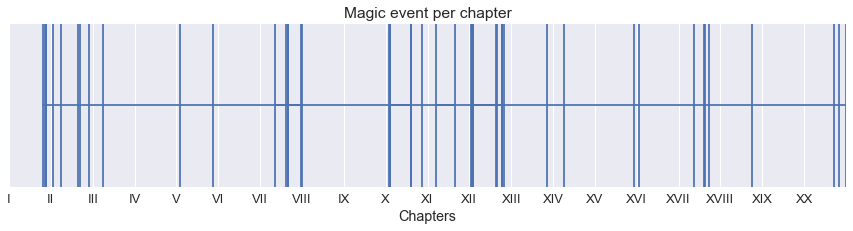

In [26]:
plt.figure(figsize=(15,3))
sns.set(font_scale=1.3)
v_val=10.0
h_val=20.0
verts = list(zip([-1., 1., 1., -1.], [-1., -1., 1., -1.]))
plt.errorbar(magic_passages_location_int, np.zeros(len(magic_passages_location_int)), yerr=10)
plt.ylim(-10,10)
plt.xlim(1, 21)
plt.xticks(np.arange(1,21), [x[0] for x in cienanos]);
plt.yticks([])
plt.title('Magic event per chapter')
plt.xlabel('Chapters');

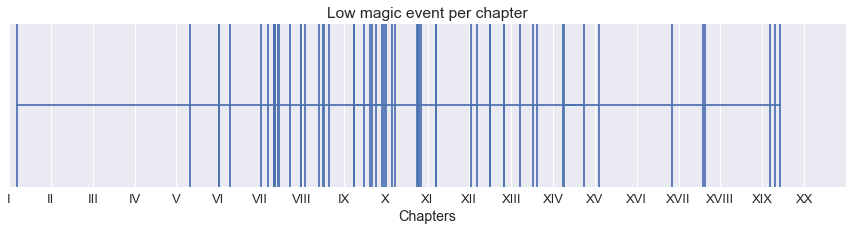

In [27]:
plt.figure(figsize=(15,3))
sns.set(font_scale=1.3)
v_val=10.0
h_val=20.0
verts = list(zip([-1., 1., 1., -1.], [-1., -1., 1., -1.]))
plt.errorbar(low_magic_passages_location_int, np.zeros(len(low_magic_passages_location_int)), yerr=10)
plt.ylim(-10,10)
plt.xlim(1, 21)
plt.xticks(np.arange(1,21), [x[0] for x in cienanos]);
plt.yticks([])
plt.title('Low magic event per chapter')
plt.xlabel('Chapters');

Print of the exact passages if needed for another form of visulization

In [28]:
pd.DataFrame(magic_passages_location, columns=['Chapter', 'Percent']).set_index('Chapter')

,Percent
Chapter,
I,0.805556
I,0.861111
I,0.888889
I,0.888889
II,0.040816
II,0.244898
II,0.653061
II,0.693878
II,0.918367


In [29]:
pd.DataFrame(low_magic_passages_location, columns=['Chapter', 'Percent']).set_index('Chapter')

,Percent
Chapter,
I,0.194444
V,0.319149
VI,0.027778
VI,0.027778
VI,0.277778
VII,0.016949
VII,0.186441
VII,0.322034
VII,0.338983


## Words and Sentence comparison

Redid the analysis, but with 4 classes, same results :D

In [30]:
def dfs_for_paragraphs(paragraphs_tokenized):
    words_per_sentence = []
    sentence_per_paragraph = []
    words_per_paragraph = []

    for paragraph in paragraphs_tokenized:
        sentence_per_paragraph.append(len(paragraph))
        words_per_paragraph.append(0)
        for sentence in paragraph:
            num_words = len(sentence)
            words_per_sentence.append(num_words)
            words_per_paragraph[-1] += num_words
    per_sentence_df = pd.DataFrame(words_per_sentence, columns=['Words per sentence'])
    per_paragraph_df = pd.DataFrame(np.stack([np.array(sentence_per_paragraph), np.array(words_per_paragraph)], axis=1), columns=['Sentence per paragraph', 'Words per paragraph'])
    return per_sentence_df, per_paragraph_df

In [31]:
per_sentence_df, per_paragraph_df = dfs_for_paragraphs(paragraphs_tokenized)

stats_df = pd.concat([per_sentence_df.describe(), per_paragraph_df.describe()], axis=1)

other_per_sentence_df, other_per_paragraph_df = dfs_for_paragraphs(paragraphs_tokenized[~magic & ~follow_up & ~low_magic])

magic_per_sentence_df, magic_per_paragraph_df = dfs_for_paragraphs(paragraphs_tokenized[magic | follow_up])

low_magic_per_sentence_df, low_magic_per_paragraph_df = dfs_for_paragraphs(paragraphs_tokenized[low_magic])

all_magic_per_sentence_df, all_magic_per_paragraph_df = dfs_for_paragraphs(paragraphs_tokenized[magic | follow_up | low_magic])

stats_df = pd.concat([
    stats_df,
    other_per_sentence_df.describe(),
    other_per_paragraph_df.describe(),
    magic_per_sentence_df.describe(),
    magic_per_paragraph_df.describe(),
    low_magic_per_sentence_df.describe(),
    low_magic_per_paragraph_df.describe(),
    all_magic_per_sentence_df.describe(),
    all_magic_per_paragraph_df.describe()
    ], axis=1)

col_index = pd.MultiIndex.from_product([['Other', 'Not Magic', 'Magic', 'Low Magic', 'All magic'], ['Words/sentence', 'Sentences/Par', 'Words/Par']])
stats_df = pd.DataFrame(stats_df.values, columns=col_index, index=stats_df.index)
stats_df

Other                                 Not Magic                \
      Words/sentence Sentences/Par    Words/Par Words/sentence Sentences/Par   
count    5336.000000    840.000000   840.000000    4254.000000    755.000000   
mean       29.661919      6.352381   188.423810      28.999765      5.634437   
std        25.296303      7.040975   241.639457      26.025178      6.489852   
min         2.000000      1.000000     3.000000       2.000000      1.000000   
25%        14.000000      1.000000    18.000000      14.000000      1.000000   
50%        26.000000      3.000000    85.500000      25.000000      2.000000   
75%        40.000000      9.000000   297.000000      39.000000      8.000000   
max      1142.000000     50.000000  1672.000000    1142.000000     41.000000   

                            Magic                                 Low Magic  \
         Words/Par Words/sentence Sentences/Par    Words/Par Words/sentence   
count   755.000000     549.000000     41.000000    41.000000     646.000000   
mean    163.397351      33.495446     13.390244   448.512195      30.936533   
std     220.235119      23.586432      7.618655   289.546294      19.793915   
min       3.000000       3.000000      3.000000    67.000000       3.000000   
25%      17.000000      19.000000     10.000000   262.000000      17.000000   
50%      48.000000      29.000000     13.000000   371.000000      28.000000   
75%     247.500000      42.000000     16.000000   592.000000      40.000000   
max    1267.000000     190.000000     34.000000  1348.000000     148.000000   

                                      All magic                             
      Sentences/Par    Words/Par Words/sentence Sentences/Par    Words/Par  
count     51.000000    51.000000    1082.000000     85.000000    85.000000  
mean      12.666667   391.862745      32.265250     12.729412   410.717647  
std        9.017021   304.371222      22.018512      8.445044   303.631615  
min        1.000000     9.000000       3.000000      1.000000     9.000000  
25%        6.000000   180.000000      17.000000      7.000000   190.000000  
50%       11.000000   318.000000      29.000000     11.000000   347.000000  
75%       16.500000   523.500000      41.000000     16.000000   549.000000  
max       50.000000  1672.000000     190.000000     50.000000  1672.000000

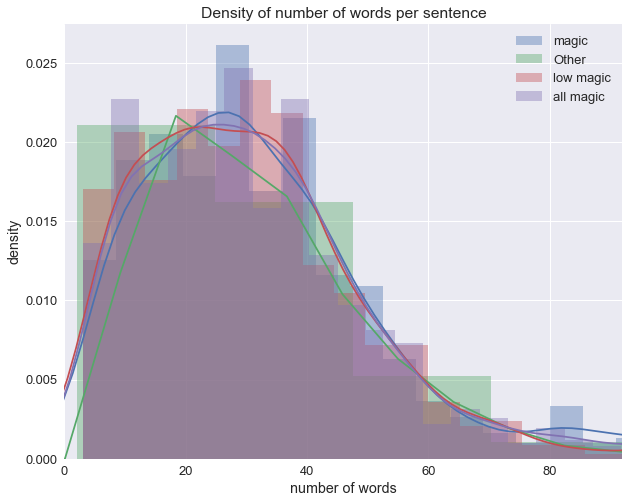

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(magic_per_sentence_df, ax=ax,hist=True, label='magic')
sns.distplot(other_per_sentence_df, ax=ax, hist=True, label='Other')
sns.distplot(low_magic_per_sentence_df, ax=ax, hist=True, label='low magic')
sns.distplot(all_magic_per_sentence_df, ax=ax, hist=True, label='all magic')
ax.set_xlim(0, per_sentence_df.quantile(0.99).max());
ax.set_ylabel("density")
ax.set_xlabel("number of words")
ax.set_title("Density of number of words per sentence")
ax.legend();

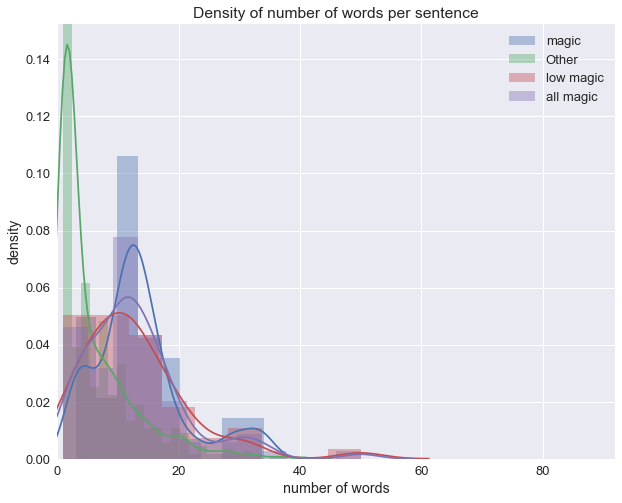

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(magic_per_paragraph_df['Sentence per paragraph'], ax=ax,hist=True, label='magic')
sns.distplot(other_per_paragraph_df['Sentence per paragraph'], ax=ax, hist=True, label='Other')
sns.distplot(low_magic_per_paragraph_df['Sentence per paragraph'], ax=ax, hist=True, label='low magic')
sns.distplot(all_magic_per_paragraph_df['Sentence per paragraph'], ax=ax, hist=True, label='all magic')
ax.set_xlim(0, per_sentence_df.quantile(0.99).max());
ax.set_ylabel("density")
ax.set_xlabel("number of words")
ax.set_title("Density of number of words per sentence")
ax.legend();

Checking the stats witht the K-S test

If it is in green, it means that the p-value is low and the correlation is high enough to accept the null hypothesis that the two distribution are not the same.

If it is in red, we reject the null hypothesis.

Results are as before, plus no real difference between all the "magic" passages, so low magic passages similar to magic passages !

In [34]:
df_dict = {'magic' : magic_per_paragraph_df, 'low magic': low_magic_per_paragraph_df, 'all magic': all_magic_per_paragraph_df, 'other': other_per_paragraph_df}
results = []
for df1_name, df1 in df_dict.items():
    results.append([])
    for df2_name, df2 in df_dict.items():
        results[-1].append(tuple(ks_2samp(df1['Sentence per paragraph'], df2['Sentence per paragraph'])))
results = pd.DataFrame(results, index=list(df_dict.keys()), columns=list(df_dict.keys()))
def highlight_res(s):
    return ['background-color: #289e28' if res[0] > 0.3 and res[1] < 1e-4 else 'background-color: #d22425' for res in s]
results.style.apply(highlight_res)

,magic,low magic,all magic,other
magic,"(0.0, 1.0)","(0.1343854615016739, 0.7765238667792136)","(0.09124820659971306, 0.9683953257238997)","(0.5587465675981264, 1.9276015096945084e-11)"
low magic,"(0.1343854615016739, 0.7765238667792136)","(0.0, 1.0)","(0.04313725490196085, 0.9999999749331817)","(0.48445656408258664, 1.497746889639954e-10)"
all magic,"(0.09124820659971306, 0.9683953257238997)","(0.04313725490196085, 0.9999999749331817)","(0.0, 1.0)","(0.4850019477989872, 1.6384226257225027e-16)"
other,"(0.5587465675981264, 1.9276015096945084e-11)","(0.48445656408258664, 1.497746889639954e-10)","(0.4850019477989872, 1.6384226257225027e-16)","(0.0, 1.0)"


### Sanity check with random paragraphs

Redid the analysis with random passages to see if due to chance or not

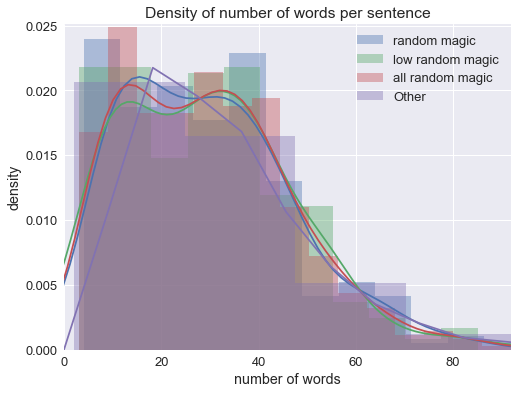

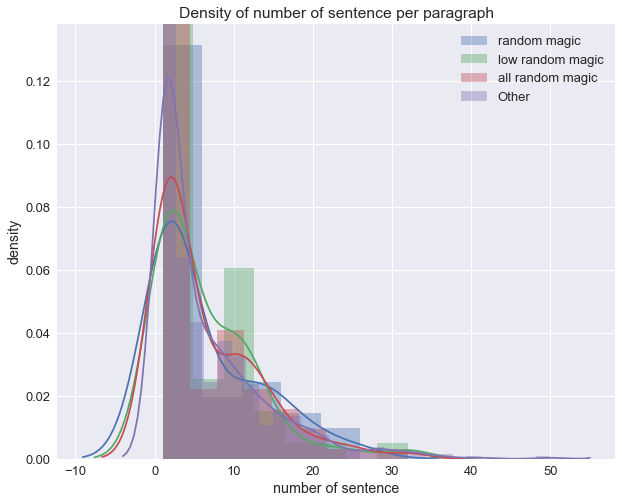

In [36]:
random_idxs = np.arange(0, len(paragraphs_tokenized))
np.random.shuffle(random_idxs)
num_magic = sum(magic | follow_up)
num_low_magic = sum(low_magic)
random_df_magic = paragraphs_tokenized[random_idxs[:num_magic]]
random_df_low_magic = paragraphs_tokenized[random_idxs[num_magic:num_magic+num_low_magic]]
random_df_all_magic = paragraphs_tokenized[random_idxs[:num_magic+num_low_magic]]
random_df_other = paragraphs_tokenized[random_idxs[num_magic+num_low_magic:]]

random_per_sentence_df_magic, random_per_paragraph_df_magic = dfs_for_paragraphs(random_df_magic)
random_per_sentence_df_low_magic, random_per_paragraph_df_low_magic = dfs_for_paragraphs(random_df_low_magic)
random_per_sentence_df_all_magic, random_per_paragraph_df_all_magic = dfs_for_paragraphs(random_df_all_magic)
random_per_sentence_df_other, random_per_paragraph_df_other = dfs_for_paragraphs(random_df_other)

fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(random_per_sentence_df_magic, ax=ax,hist=True, label='random magic')
sns.distplot(random_per_sentence_df_low_magic, ax=ax,hist=True, label='low random magic')
sns.distplot(random_per_sentence_df_all_magic, ax=ax,hist=True, label='all random magic')
sns.distplot(random_per_sentence_df_other, ax=ax, hist=True, label='Other')
ax.set_xlim(0, per_sentence_df.quantile(0.99).max());
ax.set_ylabel("density")
ax.set_xlabel("number of words")
ax.set_title("Density of number of words per sentence")
ax.legend();

fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(random_per_paragraph_df_magic['Sentence per paragraph'], ax=ax,hist=True, label='random magic')
sns.distplot(random_per_paragraph_df_low_magic['Sentence per paragraph'], ax=ax,hist=True, label='low random magic')
sns.distplot(random_per_paragraph_df_all_magic['Sentence per paragraph'], ax=ax,hist=True, label='all random magic')
sns.distplot(random_per_paragraph_df_other['Sentence per paragraph'], ax=ax, hist=True, label='Other')
ax.set_ylabel("density")
ax.set_xlabel("number of sentence")
ax.set_title("Density of number of sentence per paragraph")
ax.legend();

Some check with K-S test, this test tries to reject the null hypothesis that both datasets are coming from the same distribution. 

In [37]:
df_dict_random = {'random magic' : random_per_paragraph_df_magic,
           'random low magic': random_per_paragraph_df_low_magic,
           'random all magic': random_per_paragraph_df_all_magic,
           'other': random_per_paragraph_df_other}
results = []
for df1_name, df1 in df_dict_random.items():
    results.append([])
    for df2_name, df2 in df_dict_random.items():
        results[-1].append(tuple(ks_2samp(df1['Sentence per paragraph'], df2['Sentence per paragraph'])))
results = pd.DataFrame(results, index=list(df_dict.keys()), columns=list(df_dict.keys()))
def highlight_res(s):
    return ['background-color: #289e28' if res[0] > 0.3 and res[1] < 1e-4 else 'background-color: #d22425' for res in s]
results.style.apply(highlight_res)

,magic,low magic,all magic,other
magic,"(0.0, 1.0)","(0.09708273553323765, 0.9769178752880513)","(0.05381760339342523, 0.9999945149592562)","(0.06208425720620847, 0.9976097570925381)"
low magic,"(0.09708273553323765, 0.9769178752880513)","(0.0, 1.0)","(0.04326513213981242, 0.9999999521439643)","(0.08288770053475936, 0.8847334487307418)"
all magic,"(0.05381760339342523, 0.9999945149592562)","(0.04326513213981242, 0.9999999521439643)","(0.0, 1.0)","(0.06690304580330164, 0.8446706943134479)"
other,"(0.06208425720620847, 0.9976097570925381)","(0.08288770053475936, 0.8847334487307418)","(0.06690304580330164, 0.8446706943134479)","(0.0, 1.0)"


The test shows that for the sentence and words per paragraph for magic and non-magic, there is a high change that is does not come from the same distribution, in the other cases, it seems to be from the same distribution.

Since all red = GOOD !

### Text analysis
#### Word occurences

Again the word occurences, as always on each four categories.

This time, removing nothing, but printing a lot after.

First some processing:

In [40]:
def normalize_counter(counter, norm):
    for k in counter.keys():
        counter[k] /= norm

stopwords = nltk.corpus.stopwords.words('spanish')
punctuation = list(punctuation)
punctuation.extend(['¿', '¡', '—', '«', '»'])
names = ['aureliano', 'úrsula', 'arcadio', 'josé', 'buendía', 'amaranta', 'fernanda', 'buendia', 'melquíades', 'macondo', 'rebeca', 'prudencio', 'crespi', 'meme', 'segundo', 'aguilar', 'pietro', 'remedi']
others = ['tan', 'vez', 'después', 'si', 'aquel', 'entonces']

to_remove = stopwords + punctuation + names + others
to_remove = [] #punctuation# + ['de', 'la', 'el', 'que', 'y', 'a', 'en', 'se', 'los', 'con', 'un', 'las', 'su', 'una', 'no', 'por', 'le', 'lo', 'sus', 'era']



words_other = Counter([word.lower() for paragraph in paragraphs_tokenized[~magic & ~low_magic & ~follow_up] for sentence in paragraph for word in sentence if word.lower() not in to_remove])
words_magic = Counter([word.lower() for paragraph in paragraphs_tokenized[magic | follow_up] for sentence in paragraph for word in sentence if word.lower() not in to_remove])
words_low_magic = Counter([word.lower() for paragraph in paragraphs_tokenized[low_magic] for sentence in paragraph for word in sentence if word.lower() not in to_remove])
words_all_magic = Counter([word.lower() for paragraph in paragraphs_tokenized[low_magic | magic | follow_up] for sentence in paragraph for word in sentence if word.lower() not in to_remove])

magic_count = sum(words_magic.values())
low_magic_count = sum(words_low_magic.values())
all_magic_count = sum(words_all_magic.values())
not_magic_count = sum(words_other.values())

normalize_counter(words_other, not_magic_count/magic_count)
normalize_counter(words_magic, magic_count/magic_count)
normalize_counter(words_low_magic, low_magic_count/magic_count)
normalize_counter(words_all_magic, all_magic_count/magic_count)

Showing some stats on the word counts

In [52]:
pd.concat([pd.DataFrame(list(words_magic.values()), columns=['magic words']).describe(), pd.DataFrame(list(words_low_magic.values()), columns=['Low magic words']).describe(), 
pd.DataFrame(list(words_other.values()), columns=['Other words']).describe()], axis=1)

,magic words,Low magic words,Other words
count,4094.000000,4217.000000,13295.000000
mean,4.491695,4.360683,1.383152
std,36.140837,35.778096,20.045364
min,1.000000,0.920140,0.149062
25%,1.000000,0.920140,0.149062
50%,1.000000,0.920140,0.149062
75%,2.000000,1.840280,0.447185
max,1152.000000,1155.695972,1142.707202


Showing the 30 most frequent words, obviously only stopwords... but still able to do analysis after

In [45]:
words_other.most_common(30)

[('de', 1142.7072022048392),
 (',', 1021.9672030154419),
 ('la', 736.2158716005349),
 ('el', 697.310760750618),
 ('.', 641.8597981599319),
 ('que', 543.1809346248936),
 ('y', 471.4822437482268),
 ('a', 467.01039192639723),
 ('en', 448.6757994568962),
 ('se', 322.2714546265148),
 ('los', 285.90039314230125),
 ('con', 231.94004782555828),
 ('un', 200.0408381631743),
 ('las', 180.06656669233573),
 ('su', 170.97380132128237),
 ('una', 170.97380132128237),
 ('no', 170.67567786649371),
 ('por', 167.69444331860737),
 ('—', 166.05476431726987),
 ('le', 162.17915940501763),
 ('lo', 133.41024601791432),
 ('para', 121.33624609897458),
 ('había', 102.1072832651076),
 ('aureliano', 92.71639443926558),
 ('sus', 78.5555303368054),
 ('era', 69.90995014793498),
 ('como', 68.71745632878044),
 ('más', 64.9909131439225),
 ('pero', 61.41343168645888),
 ('cuando', 59.77375268512139)]

In [46]:
words_magic.most_common(30)

[('de', 1152.0),
 (',', 1037.0),
 ('el', 732.0),
 ('la', 698.0),
 ('.', 560.0),
 ('y', 539.0),
 ('que', 526.0),
 ('a', 483.0),
 ('en', 456.0),
 ('se', 329.0),
 ('los', 322.0),
 ('con', 247.0),
 ('un', 234.0),
 ('por', 197.0),
 ('las', 196.0),
 ('una', 187.0),
 ('no', 173.0),
 ('su', 155.0),
 ('lo', 130.0),
 ('le', 123.0),
 ('para', 122.0),
 ('había', 112.0),
 ('aureliano', 98.0),
 ('como', 80.0),
 ('sus', 76.0),
 ('era', 70.0),
 ('más', 64.0),
 ('úrsula', 63.0),
 ('pero', 63.0),
 ('arcadio', 62.0)]

Helper code

In [47]:
def color_best_worst(s, n=2):
#     is_select = s.isin(s.nlargest(n)) | s.isin(s.nsmallest(n))
    is_select = (s >= 2) | (s <= 0.5)
    return ['font-weight: bold' if (v and '/' in s.name) else '' for v in is_select]

words_magic_df = pd.DataFrame.from_dict(words_magic, orient='index').rename(columns={0: 'count'})
words_low_magic_df = pd.DataFrame.from_dict(words_low_magic, orient='index').rename(columns={0: 'count'})
words_all_magic_df = pd.DataFrame.from_dict(words_all_magic, orient='index').rename(columns={0: 'count'})
words_others_df = pd.DataFrame.from_dict(words_other, orient='index').rename(columns={0: 'count'})

### Word tables
Creating tables with the count for the words, but also the ratio of the word compared to other categories.

I highlighted those >0.5 and <=2, meaning that it was at least twice more present in one of the two categories.

The sort is done on "magic/others", since it is the category that interests us the most

In [48]:
selection = words_magic_df[words_magic_df['count'] > 8].index
df_dict_word_types = {
    'magic': words_magic_df,
    'low magic': words_low_magic_df,
    'all_magic': words_all_magic_df,
    'others': words_others_df
}
results = {}
for df1_name, df2_name in combinations(df_dict_word_types.keys(), 2):
    df1 = df_dict_word_types[df1_name]
    df2 = df_dict_word_types[df2_name]
    results["%s/%s"%(df1_name, df2_name)] = (df1[df1.index.isin(selection)]/df2[df2.index.isin(selection)]).values.reshape(-1)
    results[df1_name] = df1[df1.index.isin(selection)].values.reshape(-1)
    results[df2_name] = df2[df2.index.isin(selection)].values.reshape(-1)
# results['magic/magic']
word_count_df = pd.DataFrame.from_dict(results)
word_count_df.index = selection
column_mask = word_count_df.columns.str.contains('/')
column_order = word_count_df.columns[~column_mask].tolist() +  word_count_df.columns[column_mask].tolist()
word_count_df[column_order].sort_values(by=['magic/others', 'all_magic/others', 'low magic/others', 'magic/low magic'], ascending=False).style.apply(lambda s: color_best_worst(s, 5))

,all_magic,low magic,magic,others,all_magic/others,low magic/all_magic,low magic/others,magic/all_magic,magic/low magic,magic/others
veces,17.3824,6.44098,9,11.4778,3.29812,0.499103,1.6461,1.35605,2.71698,4.47242
hizo,57.9413,19.3229,16,12.9684,3.06254,1.34374,4.11525,1.46036,1.08679,4.47242
buendía,8.42783,17.4827,60,57.5378,2.86061,0.719295,2.05763,1.22842,1.70781,3.51404
tuvo,9.48131,20.2431,15,8.79464,2.65027,0.679335,1.80042,1.26565,1.86307,3.35432
pasó,24.7568,27.6042,12,18.4837,1.84367,0.291143,0.536772,1.74027,5.97735,3.20848
encontró,10.008,28.5243,9,10.5834,2.42942,0.952833,2.31483,1.12182,1.17736,2.72538
aunque,286.02,16.5625,10,543.181,2.31518,1.28716,2.98001,0.999196,0.776279,2.31332
puerta,18.4359,4.6007,18,58.7303,1.21852,0.349372,0.425716,1.89847,5.43396,2.31332
los,726.9,722.31,322,467.01,1.72155,1.01134,1.74107,1.29895,1.28439,2.23621
bajo,330.792,80.9723,10,10.4343,1.60249,0.851034,1.36378,1.36301,1.60159,2.18421


Same table as before, but showing only when at least one of the ratio is <= 0.5 or >= 2

In [55]:
mask = ((word_count_df[word_count_df.columns[column_mask]] >= 2.0) | (word_count_df[word_count_df.columns[column_mask]] <= 0.5)).sum(axis=1) >= 1
word_count_df[column_order][mask].sort_values(by=['magic/others', 'all_magic/others', 'low magic/others', 'magic/low magic'], ascending=False)

,all_magic,low magic,magic,others,all_magic/others,low magic/all_magic,low magic/others,magic/all_magic,magic/low magic,magic/others
veces,17.382401,6.440981,9.0,11.477753,3.298120,0.499103,1.646101,1.356051,2.716978,4.472420
hizo,57.941337,19.322942,16.0,12.968370,3.062540,1.343739,4.115253,1.460363,1.086791,4.472420
buendía,8.427831,17.482662,60.0,57.537827,2.860614,0.719295,2.057627,1.228423,1.707814,3.514044
tuvo,9.481310,20.243082,15.0,8.794642,2.650275,0.679335,1.800423,1.265648,1.863070,3.354315
pasó,24.756753,27.604203,12.0,18.483654,1.843670,0.291143,0.536772,1.740266,5.977351,3.208475
encontró,10.008049,28.524343,9.0,10.583383,2.429419,0.952833,2.314830,1.121824,1.177357,2.725381
aunque,286.019507,16.562522,10.0,543.180935,2.315183,1.287160,2.980011,0.999196,0.776279,2.313321
puerta,18.435880,4.600701,18.0,58.730321,1.218517,0.349372,0.425716,1.898472,5.433955,2.313321
los,726.900404,722.309982,322.0,467.010392,1.721546,1.011340,1.741069,1.298954,1.284389,2.236210
bajo,330.792358,80.972329,10.0,10.434321,1.602492,0.851034,1.363776,1.363005,1.601587,2.184205


## POS analysis


Analysis using the Part of speech tagging.

First some helper code.

In [57]:
ancora_annot = pd.read_excel('ancora_annot.xls').set_index('Code')
code2class = ancora_annot.to_dict()['Class']
code2descr = ancora_annot.to_dict()['Description']
code2example = ancora_annot.to_dict()['Example']
descr2class = ancora_annot.reset_index().set_index('Description').to_dict()['Class']
code2verb = (ancora_annot[ancora_annot['Class'] == 'Verbs']['Description']
             .str.extract(r".*\((.*)\)").str.split(',')
             .apply(lambda x: " ".join([y.strip() for y in x[1:]])).to_dict())

paragraphs_tagged_raw = []

for i in range(len(paragraphs)):
    with open('./text_per_paragrah/paragraph_%d_tagged'%i, 'r') as infile:
        paragraphs_tagged_raw.append(infile.read())
        
paragraphs_tagged = []
for p in paragraphs_tagged_raw:
    paragraphs_tagged.append([])
    words = p.split()
    for word in words:
        word, code = tuple(word.split('_'))
        descr = np.nan
        class_ = np.nan
        verb = np.nan
        if code in code2descr:
            descr = code2descr[code]
        if code in code2class:
            class_ = code2class[code]
        if code in code2verb:
            verb = code2verb[code]
        paragraphs_tagged[-1].append((word, descr, class_, verb))
paragraphs_tagged = np.array(paragraphs_tagged)

num_words_magic = pd.DataFrame(paragraphs_tagged[magic | follow_up].sum())[1].value_counts().sum()

Showing the different levels:
1. General "class" of the word
2. Specific "type" fo the word
3. Showing only verbs tense

In [58]:
word_type_magic_class = pd.DataFrame(paragraphs_tagged[magic | follow_up].sum())[2].value_counts(normalize=True).reset_index().rename(columns={'index' : 'Class',2: 'count'}).set_index('Class') * num_words_magic
word_type_low_magic_class =  pd.DataFrame(paragraphs_tagged[low_magic].sum())[2].value_counts(normalize=True).reset_index().rename(columns={'index' : 'Class',2: 'count'}).set_index('Class') * num_words_magic
word_type_all_magic_class = pd.DataFrame(paragraphs_tagged[low_magic | magic | follow_up].sum())[2].value_counts(normalize=True).reset_index().rename(columns={'index' : 'Class',2: 'count'}).set_index('Class') * num_words_magic
word_type_others_class = pd.DataFrame(paragraphs_tagged[~low_magic & ~magic & ~follow_up].sum())[2].value_counts(normalize=True).reset_index().rename(columns={'index' : 'Class',2: 'count'}).set_index('Class') * num_words_magic
word_type_magic_class

,count
Class,
Nouns,4243.0
Prepositions,2862.0
Determiners,2664.0
Verbs,2386.0
Punctuation,1688.0
Adjectives,1175.0
Conjunctions,1121.0
Pronouns,1096.0
Adverbs,687.0


In [643]:
word_type_magic_descr = pd.DataFrame(paragraphs_tagged[magic | follow_up].sum())[1].value_counts(normalize=True).reset_index().rename(columns={'index' : 'Function',1: 'count'}).set_index('Function') * num_words_magic
word_type_low_magic_descr =  pd.DataFrame(paragraphs_tagged[low_magic].sum())[1].value_counts(normalize=True).reset_index().rename(columns={'index' : 'Function',1: 'count'}).set_index('Function') * num_words_magic
word_type_all_magic_descr = pd.DataFrame(paragraphs_tagged[low_magic | magic | follow_up].sum())[1].value_counts(normalize=True).reset_index().rename(columns={'index' : 'Function',1: 'count'}).set_index('Function') * num_words_magic
word_type_others_descr = pd.DataFrame(paragraphs_tagged[~low_magic & ~magic & ~follow_up].sum())[1].value_counts(normalize=True).reset_index().rename(columns={'index' : 'Function',1: 'count'}).set_index('Function') * num_words_magic
word_type_magic_descr.head()

,count
Function,
Preposition,2862.0
Common noun (singular),2541.0
Article (definite),1682.0
Adjective (descriptive),1134.0
Comma,1037.0


In [650]:
num_verbs_magic = pd.DataFrame(paragraphs_tagged[magic | follow_up].sum())[3].dropna().value_counts().sum()

word_type_magic_verbs = pd.DataFrame(paragraphs_tagged[magic | follow_up].sum())[3].dropna().value_counts(normalize=True).reset_index().rename(columns={'index' : 'Function', 3: 'count'}).set_index('Function') * num_words_magic
word_type_low_magic_verbs =  pd.DataFrame(paragraphs_tagged[low_magic].sum())[3].dropna().value_counts(normalize=True).reset_index().rename(columns={'index' : 'Function',3: 'count'}).set_index('Function') * num_words_magic
word_type_all_magic_verbs = pd.DataFrame(paragraphs_tagged[low_magic | magic | follow_up].sum())[3].dropna().value_counts(normalize=True).reset_index().rename(columns={'index' : 'Function',3: 'count'}).set_index('Function') * num_words_magic
word_type_others_verbs = pd.DataFrame(paragraphs_tagged[~low_magic & ~magic & ~follow_up].sum())[3].dropna().value_counts(normalize=True).reset_index().rename(columns={'index' : 'Function',3: 'count'}).set_index('Function') * num_words_magic
word_type_magic_verbs

,count
Function,
indicative preterite,6377.770327
indicative imperfect,5054.082146
infinitive,2617.292540
participle,1451.544426
gerund,872.430847
subjunctive imperfect,691.927913
indicative present,376.047779
indicative conditional,225.628667
imperative,127.856245


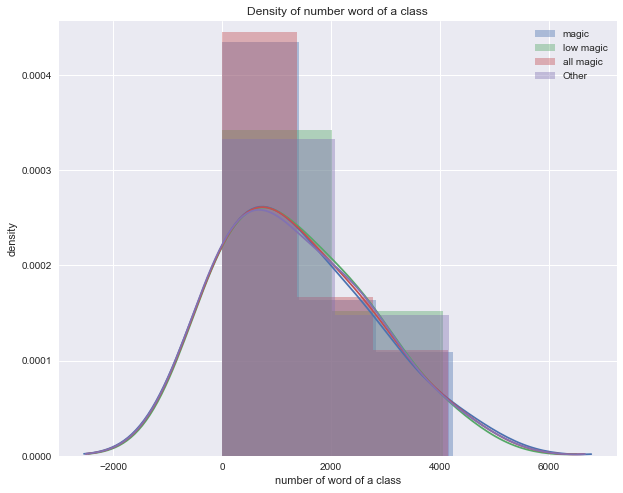

In [547]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(word_type_magic_class, ax=ax,hist=True, label='magic')
sns.distplot(word_type_low_magic_class, ax=ax,hist=True, label='low magic')
sns.distplot(word_type_all_magic_class, ax=ax,hist=True, label='all magic')
sns.distplot(word_type_others_class, ax=ax, hist=True, label='Other')
ax.set_ylabel("density")
ax.set_xlabel("number of word of a class")
ax.set_title("Density of number word of a class")
ax.legend();

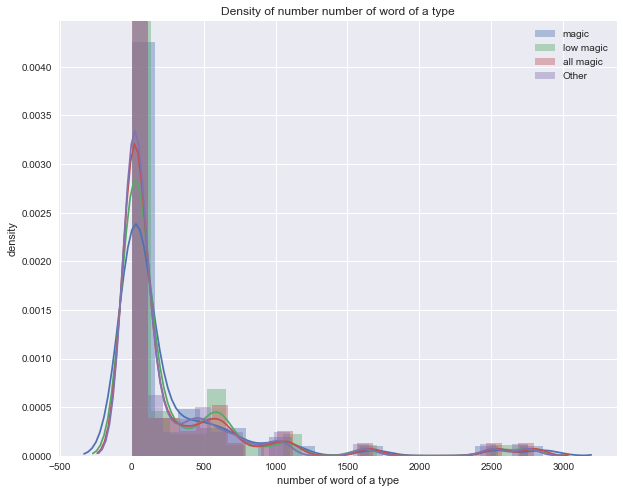

In [549]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(word_type_magic_descr, ax=ax,hist=True, label='magic')
sns.distplot(word_type_low_magic_descr, ax=ax,hist=True, label='low magic')
sns.distplot(word_type_all_magic_descr, ax=ax,hist=True, label='all magic')
sns.distplot(word_type_others_descr, ax=ax, hist=True, label='Other')
ax.set_ylabel("density")
ax.set_xlabel("number of word of a type")
ax.set_title("Density of number number of word of a type")
ax.legend();

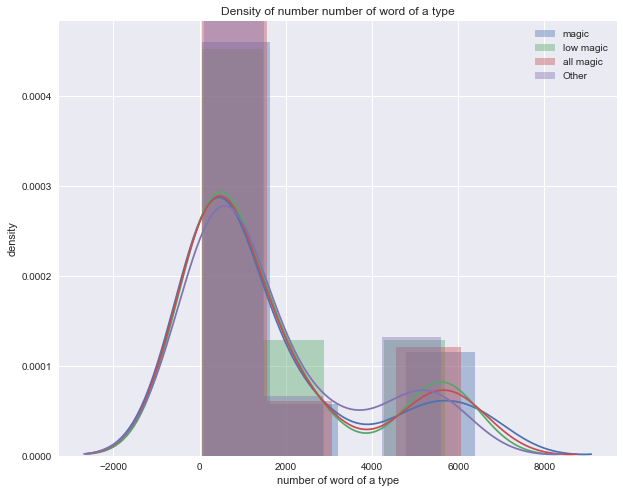

In [651]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(word_type_magic_verbs, ax=ax,hist=True, label='magic')
sns.distplot(word_type_low_magic_verbs, ax=ax,hist=True, label='low magic')
sns.distplot(word_type_all_magic_verbs, ax=ax,hist=True, label='all magic')
sns.distplot(word_type_others_verbs, ax=ax, hist=True, label='Other')
ax.set_ylabel("density")
ax.set_xlabel("number of word of a type")
ax.set_title("Density of number number of word of a type")
ax.legend();

Same idea of table as before, highlighting differences of more than twice.

In [652]:
selection = word_type_magic_class[word_type_magic_class['count'] > 2].index
df_dict_word_types = {
    'magic': word_type_magic_class,
    'low magic': word_type_low_magic_class,
    'all_magic': word_type_all_magic_class,
    'others': word_type_others_class
}
results = {}
for df1_name, df2_name in combinations(df_dict_word_types.keys(), 2):
    df1 = df_dict_word_types[df1_name]
    df2 = df_dict_word_types[df2_name]
    results["%s/%s"%(df1_name, df2_name)] = (df1[df1.index.isin(selection)]/df2[df2.index.isin(selection)]).values.reshape(-1)
    results[df1_name] = df1[df1.index.isin(selection)].values.reshape(-1)
    results[df2_name] = df2[df2.index.isin(selection)].values.reshape(-1)
    # results['magic/magic']
word_class_df = pd.DataFrame.from_dict(results)
word_class_df.index = selection
column_mask = word_class_df.columns.str.contains('/')
column_order = word_class_df.columns[~column_mask].tolist() +  word_class_df.columns[column_mask].tolist()
word_class_df[column_order].style.apply(color_best_worst)

,all_magic,low magic,magic,others,all_magic/others,low magic/all_magic,low magic/others,magic/all_magic,magic/low magic,magic/others
Class,,,,,,,,,,
Nouns,4150.15,4049.57,4243,4161.36,1.05528,1.00204,0.973137,1.01808,1.016,1.07436
Prepositions,2798.92,2755.88,2862,2752.43,1.03556,1.03499,1.00126,0.975016,0.942058,1.00968
Determiners,2675.6,2645.39,2664,2575.52,1.0766,1.01012,1.02713,0.989358,0.979446,1.06514
Verbs,2409.99,2439.14,2386,2490.81,1.20247,1.10655,0.979254,0.94876,0.857401,1.14085
Punctuation,1751.23,1800.12,1688,1953.23,1.03886,0.98871,0.921609,0.995666,1.00704,1.03435
Adjectives,1154.14,1185.04,1175,1159.87,0.997307,0.975764,1.0217,1.02237,1.04777,1.01962
Conjunctions,1136.75,1156.49,1121,1093.68,1.4569,1.47132,1.05744,0.499347,0.339388,0.727501
Pronouns,1133.06,1144.52,1096,1052.44,1.01689,0.984625,1.08749,1.02254,1.03851,1.03981
Adverbs,704.604,729.254,687,680.412,0.980066,1.04248,1.07178,0.964155,0.924864,0.944936


Not very interesting differences...

In [653]:
selection = word_type_magic_descr[word_type_magic_descr['count'] > 100].index
df_dict_word_types = {
    'magic': word_type_magic_descr,
    'low magic': word_type_low_magic_descr,
    'all_magic': word_type_all_magic_descr,
    'others': word_type_others_descr
}
results = {}
for df1_name, df2_name in combinations(df_dict_word_types.keys(), 2):
    df1 = df_dict_word_types[df1_name]
    df2 = df_dict_word_types[df2_name]
    results["%s/%s"%(df1_name, df2_name)] = (df1[df1.index.isin(selection)]/df2[df2.index.isin(selection)]).values.reshape(-1)
    results[df1_name] = df1[df1.index.isin(selection)].values.reshape(-1)
    results[df2_name] = df2[df2.index.isin(selection)].values.reshape(-1)
    # results['magic/magic']
word_type_df = pd.DataFrame.from_dict(results)
word_type_df.index = selection
column_mask = word_type_df.columns.str.contains('/')
column_order = word_type_df.columns[~column_mask].tolist() +  word_type_df.columns[column_mask].tolist()
word_type_df[column_order].style.apply(color_best_worst)

,all_magic,low magic,magic,others,all_magic/others,low magic/all_magic,low magic/others,magic/all_magic,magic/low magic,magic/others
Function,,,,,,,,,,
Preposition,2798.92,2755.88,2862,2752.43,1.06494,1.00124,1.06626,1.02077,1.01951,1.08706
Common noun (singular),2538.58,2529.37,2541,2510.08,1.04587,1.03761,1.08521,0.96376,0.928827,1.00797
Article (definite),1658.48,1616.88,1682,1622.74,1.00469,1.02681,1.03163,1.01006,0.983691,1.0148
Adjective (descriptive),1110.92,1112.3,1134,1043.18,1.02203,0.974918,0.996391,1.01418,1.04027,1.03652
Comma,1052.43,1053.37,1037,1024.2,1.13529,1.01668,1.15423,0.976569,0.960543,1.10869
Common noun (plural),925.945,875.658,976,887.942,1.02756,1.00089,1.02847,0.985342,0.984462,1.01249
"Verb (main, indicative, preterite)",759.939,722.809,790,744.06,1.0428,0.945691,0.986166,1.05406,1.11459,1.09917
Proper noun,665.079,626.128,703,723.89,1.01135,0.996374,1.00768,1.00095,1.0046,1.01232
Conjunction (coordinating),645.579,621.524,666,643.358,1.08238,0.961311,1.04051,1.03163,1.07315,1.11662


No real differences for this one.

In [657]:
selection = word_type_magic_verbs[word_type_magic_verbs['count'] > 0].index
df_dict_word_types = {
    'magic': word_type_magic_verbs,
    'low magic': word_type_low_magic_verbs,
    'all_magic': word_type_all_magic_verbs,
    'others': word_type_others_verbs
}
results = {}
for df1_name, df2_name in combinations(df_dict_word_types.keys(), 2):
    df1 = df_dict_word_types[df1_name]
    df2 = df_dict_word_types[df2_name]
    results["%s/%s"%(df1_name, df2_name)] = (df1[df1.index.isin(selection)]/df2[df2.index.isin(selection)]).values.reshape(-1)
    results[df1_name] = df1[df1.index.isin(selection)].values.reshape(-1)
    results[df2_name] = df2[df2.index.isin(selection)].values.reshape(-1)

word_verbs_df = pd.DataFrame.from_dict(results)
word_verbs_df.index = selection
column_mask = word_verbs_df.columns.str.contains('/')
column_order = word_verbs_df.columns[~column_mask].tolist() +  word_verbs_df.columns[column_mask].tolist()
word_verbs_df[column_order].style.apply(color_best_worst)

,all_magic,low magic,magic,others,all_magic/others,low magic/all_magic,low magic/others,magic/all_magic,magic/low magic,magic/others
Function,,,,,,,,,,
indicative preterite,6066.69,5690.37,6377.77,5602.77,0.925239,0.93797,0.905355,1.02454,1.04704,0.947945
indicative imperfect,5254.4,5514.24,5054.08,4860.04,0.718059,1.04945,0.71515,1.25316,1.25826,0.899842
infinitive,2531.06,2465.83,2617.29,2796.54,1.52718,0.974229,1.74342,0.927386,0.812361,1.41629
participle,1514.71,1571.63,1451.54,1441.33,0.500367,1.03758,0.555293,1.0952,0.986868,0.548001
gerund,851.534,833.233,872.431,931.103,1.08114,0.978509,1.13461,0.961877,0.91655,1.03993
subjunctive imperfect,769.127,812.911,691.928,920.339,0.455164,1.05693,0.480184,0.887313,0.841081,0.403873
indicative present,423.805,447.101,376.048,735.195,1.0828,1.05497,1.01564,1.05128,1.1208,1.13833
indicative conditional,243.295,277.744,225.629,246.5,0.905068,1.14159,0.881743,1.03407,1.06143,0.935904
imperative,133.42,169.356,127.856,159.31,1.05091,1.26935,1.0904,0.958298,0.923593,1.00709


Some differences that may be interesting, but I'm not sure...

## Characters name appearance

In [122]:
names_family = ["José Arcadio Buendía","Úrsula Iguarán", "Úrsula", "Rebeca","José Arcadio","Pilar Ternera", "Aureliano", "Amaranta", "Remedios", "Pietro Crespi", "Arcadio",  "Aureliano José", "Santa Sofía de la Piedad", "Remedios, la bella","Meme","José Arcadio Segundo","Aureliano Segundo","Fernanda del Carpio","Mauricio Babilonia", "Amaranta Úrsula", "Italiano", "Nigromanta",  "Aureliano Babilonia"]
names_family_regex = ["José Arcadio Buendía","Úrsula Iguarán", r"(?<!Amaranta )Úrsula", "Rebeca",r"José Arcadio(?!(?: Buendía| Segundo))","Pilar Ternera", r"Aureliano(?!(?: José| Babilonia| Segundo))", r"Amaranta(?! Úrsula)", r"Remedios(?!, la bella)", "Pietro Crespi", r"(?<!José )Arcadio(?!(?: José| Segundo))",  "Aureliano José", "Santa Sofía de la Piedad", "Remedios, la bella","Meme","José Arcadio Segundo","Aureliano Segundo","Fernanda del Carpio","Mauricio Babilonia", "Amaranta Úrsula", "Italiano", "Nigromanta",  "Aureliano Babilonia"]
names_others = ["Melquíades", "gitanos", "pueblo"]

In [150]:
magic_mask = magic | follow_up
all_magic_mask = magic_mask | low_magic
others_mask = ~magic_mask & ~low_magic

magic_appearance = []
low_magic_appearance = []
all_magic_appearance = []
other_appearance = []
all_appearance = []

In [151]:
current_paragraph = 0
for chapter, paragraphs in cienanos:
    for par_idx, paragraph in enumerate(paragraphs):
        for idx, regex in enumerate(names_family_regex):
            m = re.findall(regex, paragraph)
            if len(m) > 0:
                current = (chapter, (par_idx+1)/len(paragraphs), names_family[idx], len(m))
                all_appearance.append(current)
                if magic_mask[current_paragraph]:
                    magic_appearance.append(current)
                if low_magic[current_paragraph]:
                    low_magic_appearance.append(current)
                if all_magic_mask[current_paragraph]:
                    all_magic_appearance.append(current)
                if others_mask[current_paragraph]:
                    other_appearance.append(current)
        current_paragraph += 1

In [152]:
magic_appearance_df = pd.DataFrame(magic_appearance, columns=['Chapter', 'Percent of chapter', 'Character', 'Number of appearance'])
low_magic_appearance_df = pd.DataFrame(low_magic_appearance, columns=['Chapter', 'Percent of chapter', 'Character', 'Number of appearance'])
all_magic_appearance_df = pd.DataFrame(all_magic_appearance, columns=['Chapter', 'Percent of chapter', 'Character', 'Number of appearance'])
other_appearance_df = pd.DataFrame(other_appearance, columns=['Chapter', 'Percent of chapter', 'Character', 'Number of appearance'])
all_appearance_df = pd.DataFrame(all_appearance, columns=['Chapter', 'Percent of chapter', 'Character', 'Number of appearance'])

In [157]:
appearance_dict = {
    'Magic': magic_appearance_df,
    'Low magic': low_magic_appearance_df,
    'All magic': all_magic_appearance_df,
    'Other': other_appearance_df,
    'All' : all_appearance_df
}
appearance_df = pd.concat([
    magic_appearance_df,
    low_magic_appearance_df,
    all_magic_appearance_df,
    other_appearance_df,
    all_appearance_df], axis=1, keys=['Magic', 'Low magic', 'All magic', 'Other', 'All'])
appearance_df.describe()

Magic                               Low magic  \
      Percent of chapter Number of appearance Percent of chapter   
count         137.000000           137.000000         146.000000   
mean            0.557392             2.043796           0.472156   
std             0.316019             1.727241           0.284150   
min             0.030303             1.000000           0.016949   
25%             0.256410             1.000000           0.225202   
50%             0.658537             1.000000           0.432460   
75%             0.805556             2.000000           0.741935   
max             1.000000            11.000000           1.000000   

                                    All magic                       \
      Number of appearance Percent of chapter Number of appearance   
count           146.000000         267.000000           267.000000   
mean              2.143836           0.513084             2.063670   
std               1.989593           0.299604             1.806336   
min               1.000000           0.016949             1.000000   
25%               1.000000           0.225806             1.000000   
50%               1.000000           0.625000             1.000000   
75%               2.000000           0.750000             2.000000   
max              11.000000           1.000000            11.000000   

                   Other                                     All  \
      Percent of chapter Number of appearance Percent of chapter   
count        1156.000000          1156.000000        1423.000000   
mean            0.473518             1.762976           0.480942   
std             0.297172             1.327386           0.297925   
min             0.012048             1.000000           0.012048   
25%             0.219167             1.000000           0.220000   
50%             0.458896             1.000000           0.479167   
75%             0.730631             2.000000           0.738615   
max             1.000000            10.000000           1.000000   

                            
      Number of appearance  
count          1423.000000  
mean              1.819396  
std               1.433619  
min               1.000000  
25%               1.000000  
50%               1.000000  
75%               2.000000  
max              11.000000

In [240]:

magic_appearance_char_df = magic_appearance_df[['Character', 'Number of appearance']].groupby('Character').sum()
num_magic_appearance = magic_appearance_char_df.sum()[0]
magic_appearance_char_df /= (magic_appearance_char_df.sum()/num_magic_appearance)

low_magic_appearance_char_df = low_magic_appearance_df[['Character', 'Number of appearance']].groupby('Character').sum()
low_magic_appearance_char_df /= (low_magic_appearance_char_df.sum()/num_magic_appearance)

all_magic_appearance_char_df = all_magic_appearance_df[['Character', 'Number of appearance']].groupby('Character').sum()
all_magic_appearance_char_df /= (all_magic_appearance_char_df.sum()/num_magic_appearance)

other_appearance_char_df = other_appearance_df[['Character', 'Number of appearance']].groupby('Character').sum()
other_appearance_char_df /= (other_appearance_char_df.sum()/num_magic_appearance)

all_appearance_char_df = all_appearance_df[['Character', 'Number of appearance']].groupby('Character').sum()
all_appearance_char_df /= (all_appearance_char_df.sum()/num_magic_appearance)

In [241]:
pd.concat([
    magic_appearance_char_df,
    low_magic_appearance_char_df,
    all_magic_appearance_char_df,
    other_appearance_char_df,
    all_appearance_char_df,
], axis=1)

,Number of appearance,Number of appearance,Number of appearance,Number of appearance,Number of appearance
Amaranta,21.0,33.993610,24.392015,24.317959,24.333720
Amaranta Úrsula,9.0,6.261981,8.130672,9.479882,9.192739
Arcadio,3.0,0.894569,2.032668,12.090285,9.949788
Aureliano,68.0,53.674121,60.471869,60.176644,60.239475
Aureliano Babilonia,1.0,NaN,0.508167,NaN,0.108150
Aureliano José,2.0,6.261981,4.573503,3.846909,4.001545
Aureliano Segundo,30.0,21.469649,25.408348,21.707556,22.495172
Fernanda del Carpio,1.0,0.894569,1.016334,0.412169,0.540749
José Arcadio,14.0,9.840256,12.704174,15.112856,14.600232
José Arcadio Buendía,31.0,8.945687,18.802178,18.135427,18.277327


In [257]:
# selection = magic_appearance_char_df[magic_appearance_char_df['Magic'] > 3].index
full_index = all_appearance_char_df.index
df_dict_word_types = {
    'magic': magic_appearance_char_df,
    'low magic': low_magic_appearance_char_df,
    'all_magic': all_magic_appearance_char_df,
    'others': other_appearance_char_df,
    'all': all_appearance_char_df
}
results = {}
for df1_name, df2_name in combinations(df_dict_word_types.keys(), 2):
    df1 = df_dict_word_types[df1_name]
    df2 = df_dict_word_types[df2_name]
    results["%s/%s"%(df1_name, df2_name)] = pd.DataFrame((df1/df2), index=full_index).values.reshape(-1)
    results[df1_name] = pd.DataFrame(df1, index=full_index).values.reshape(-1)
    results[df2_name] = pd.DataFrame(df2, index=full_index).values.reshape(-1)
    # results['magic/magic']
word_type_df = pd.DataFrame.from_dict(results)
word_type_df.index = full_index
column_mask = word_type_df.columns.str.contains('/')
column_order = word_type_df.columns[~column_mask].tolist() +  word_type_df.columns[column_mask].tolist()
word_type_df[column_order].style.apply(color_best_worst)

,all,all_magic,low magic,magic,others,all_magic/all,all_magic/others,low magic/all,low magic/all_magic,low magic/others,magic/all,magic/all_magic,magic/low magic,magic/others,others/all
Character,,,,,,,,,,,,,,,
Amaranta,24.3337,24.392,33.9936,21,24.318,1.0024,1.00305,1.39698,1.39364,1.39788,0.863,0.860937,0.617763,0.863559,0.999352
Amaranta Úrsula,9.19274,8.13067,6.26198,9,9.47988,0.884467,0.857676,0.681188,0.770168,0.660555,0.979034,1.10692,1.43724,0.949379,1.03124
Arcadio,9.94979,2.03267,0.894569,3,12.0903,0.204293,0.168124,0.0899083,0.440096,0.0739907,0.301514,1.47589,3.35357,0.248133,1.21513
Aureliano,60.2395,60.4719,53.6741,68,60.1766,1.00386,1.00491,0.891012,0.887588,0.891943,1.12883,1.12449,1.2669,1.13001,0.998957
Aureliano Babilonia,0.10815,0.508167,nan,1,nan,4.69873,nan,nan,nan,nan,9.24643,1.96786,nan,nan,nan
Aureliano José,4.00154,4.5735,6.26198,2,3.84691,1.14293,1.18888,1.56489,1.36919,1.6278,0.499807,0.437302,0.319388,0.519898,0.961356
Aureliano Segundo,22.4952,25.4083,21.4696,30,21.7076,1.1295,1.17048,0.954411,0.844984,0.98904,1.33362,1.18071,1.39732,1.38201,0.964987
Fernanda del Carpio,0.540749,1.01633,0.894569,1,0.412169,1.87949,2.46582,1.65431,0.880192,2.17039,1.84929,0.983929,1.11786,2.42619,0.762218
José Arcadio,14.6002,12.7042,9.84026,14,15.1129,0.870135,0.84062,0.673979,0.774569,0.651118,0.958889,1.102,1.42273,0.926364,1.03511
